In [1]:
#!/usr/bin/env python`
# -*- coding: utf-8 -*-

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
import torch

from collections.abc import Callable
from typing import Literal

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import sys

from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix, fn_plot_torch_hist

In [3]:
print(fn_plot_tf_hist.__doc__)


    Args:
        hist_df: a dataframe with following ccolumns
            column 0: loss
            column 1: accuracy
            column 2: val_loss
            column 3: val_accuracy
            While plotting columns are accessed by index 
            so that even if the column names are different it will not throw exceptions.
    


In [4]:
print (fn_plot_confusion_matrix.__doc__)


    Args:
        y_true: Ground Truth 
        y_pred : Predictions
        labels : dictonary 
                  {0: 'Goal Keeper', 
                  1: 'Defender', 
                  2: 'Mid-Fielder', 
                  3: 'Forward'}
    
    


In [5]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../input'
outDir = '../output'
modelDir = './models'
subDir = 'fifa_2019'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results
tf.random.set_seed(RANDOM_STATE) # setting for Tensorflow as well


EPOCHS = 101 # number of epochs
ALPHA = 0.001 # learning rate

BATCH_SIZE = 32
TEST_SIZE = 0.2
REG_LAMBDA = 0.001


# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'medium',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Read FIFA 2019 data set

In [6]:
data_df = pd.read_csv(os.path.join(inpDir, 'fifa_2019.csv'))
data_df.shape

(18207, 89)

In [7]:
#data_df.columns

In [8]:
# removing rows with position = null
data_df = data_df[data_df["Position"].notnull()]
#data_df.head()

In [9]:
#data_df['Position'].isnull()

In [10]:
# Following columns appear to be relevant for our analysis
rel_cols = ["Position", 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
            'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
            'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
            'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
            'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
            'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
            'GKKicking', 'GKPositioning', 'GKReflexes']

In [11]:
goalkeeper = 'GK'
forward = ['ST', 'LW', 'RW', 'LF', 'RF', 'RS','LS', 'CF']
midfielder = ['CM','RCM','LCM', 'CDM','RDM','LDM', 'CAM', 'LAM', 'RAM', 'RM', 'LM']
defender = ['CB', 'RCB', 'LCB', 'LWB', 'RWB', 'LB', 'RB']

In [12]:
#Assign labels to goalkeepers
data_df.loc[data_df["Position"] == "GK", "Position"] = 0

#Defenders
data_df.loc[data_df["Position"].isin(defender), "Position"] = 1

#Midfielders
data_df.loc[data_df["Position"].isin(midfielder), "Position"] = 2

#Forward
data_df.loc[data_df["Position"].isin(forward), "Position"] = 3

# Convert Column "Position" to numeric so that Pandas does not complain
data_df['Position'] = pd.to_numeric(data_df['Position'], downcast="integer")

In [13]:
data_df = data_df[rel_cols]
#data_df.head()

In [14]:
labels101 = {0: 'Goal Keeper', 1: 'Defender', 2: 'Mid-Fielder', 3: 'Forward'}

In [15]:
features_df = data_df.drop('Position', axis = 1)
labels = data_df['Position']

In [16]:
data_df['Position'].isnull().sum()

0

In [17]:
# splitting in train ans test datasets
X_train, X_test, y_train, y_test = train_test_split(features_df, labels,
                                     stratify=labels,
                                     test_size=TEST_SIZE, 
                                     random_state=RANDOM_STATE )
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14517, 33), (3630, 33), (14517,), (3630,))

In [18]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [19]:
X_train.shape

(14517, 33)

In [20]:
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# defining model

In [21]:
# 33 -> 23 -> 12 -> 4 -> 4 #diving layers

# without regularizer

In [22]:

k_init = tf.keras.initializers.GlorotUniform(seed=RANDOM_STATE)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = (33,)),
    tf.keras.layers.Dense(33, activation='relu', kernel_initializer = k_init),
    #tf.keras.layers.ReLU()
    tf.keras.layers.Dense(23, activation='relu', kernel_initializer=k_init),
    tf.keras.layers.Dense(12, activation='relu',  kernel_initializer=k_init),
    tf.keras.layers.Dense(4, activation='relu', kernel_initializer=k_init),
    tf.keras.layers.Dense(4)
])


In [23]:
model(X_train[:1])

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[ 0.01227756, -0.08197653,  0.21723892, -0.22544809]],
      dtype=float32)>

In [24]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate = ALPHA)

In [25]:
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=2
                   )

Epoch 1/101


454/454 - 4s - loss: 0.5300 - accuracy: 0.7540 - val_loss: 0.3403 - val_accuracy: 0.8576 - 4s/epoch - 8ms/step
Epoch 2/101
454/454 - 1s - loss: 0.3217 - accuracy: 0.8667 - val_loss: 0.3230 - val_accuracy: 0.8661 - 1s/epoch - 3ms/step
Epoch 3/101
454/454 - 1s - loss: 0.3055 - accuracy: 0.8751 - val_loss: 0.3167 - val_accuracy: 0.8667 - 1s/epoch - 3ms/step
Epoch 4/101
454/454 - 1s - loss: 0.2972 - accuracy: 0.8771 - val_loss: 0.3063 - val_accuracy: 0.8708 - 1s/epoch - 3ms/step
Epoch 5/101
454/454 - 1s - loss: 0.2908 - accuracy: 0.8797 - val_loss: 0.3091 - val_accuracy: 0.8694 - 1s/epoch - 3ms/step
Epoch 6/101
454/454 - 1s - loss: 0.2862 - accuracy: 0.8832 - val_loss: 0.3028 - val_accuracy: 0.8744 - 1s/epoch - 3ms/step
Epoch 7/101
454/454 - 2s - loss: 0.2837 - accuracy: 0.8825 - val_loss: 0.3034 - val_accuracy: 0.8749 - 2s/epoch - 3ms/step
Epoch 8/101
454/454 - 1s - loss: 0.2807 - accuracy: 0.8826 - val_loss: 0.3064 - val_accuracy: 0.8744 - 1s/epoch - 3ms/step
Epoch 9/101
45

In [26]:
loss_df = pd.DataFrame(history.history)
loss_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.529981,0.754013,0.340336,0.857576
1,0.321737,0.866708,0.323016,0.866116
2,0.305525,0.875112,0.316743,0.866667
3,0.297211,0.877110,0.306326,0.870799
4,0.290819,0.879658,0.309051,0.869421


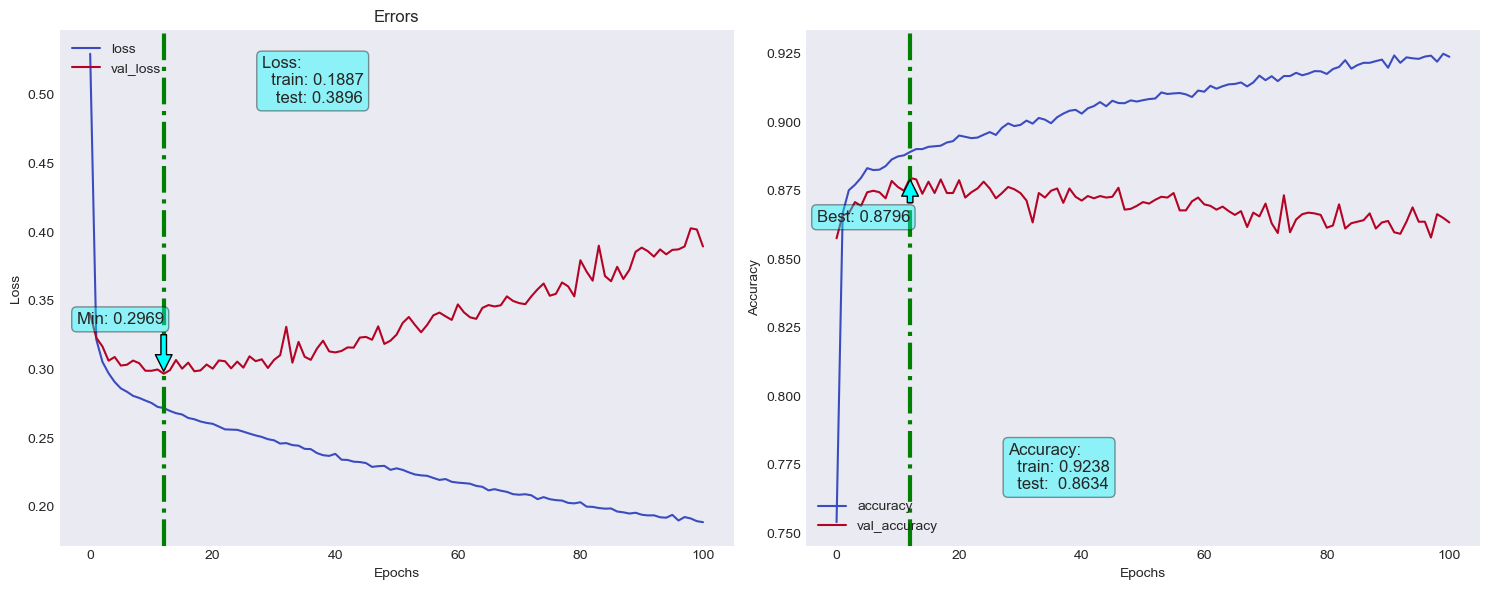

In [27]:
fn_plot_tf_hist(loss_df)

# with regularizers

In [28]:

#initializer
k_init = tf.keras.initializers.GlorotUniform(seed=RANDOM_STATE)
#regularizer
k_reg = tf.keras.regularizers.L2(l2=REG_LAMBDA)

model = tf.keras.Sequential([
      #input layer
    tf.keras.layers.InputLayer(input_shape = (33,)),
    
    #set 1
    tf.keras.layers.Dense(33, activation='relu', 
                          kernel_initializer = k_init, 
                          kernel_regularizer=k_reg),
    #tf.keras.layers.ReLU()

    #set 2
    tf.keras.layers.Dense(23, activation='relu', 
                          kernel_initializer=k_init, 
                          kernel_regularizer=k_reg),
    #set 3
    tf.keras.layers.Dense(12, activation='relu', 
                          kernel_initializer=k_init, 
                          kernel_regularizer=k_reg),
    #set 4
    tf.keras.layers.Dense(4, activation='relu', 
                          kernel_initializer=k_init, 
                          kernel_regularizer=k_reg),

    #output layer
    tf.keras.layers.Dense(4)
])

In [29]:
model(X_train[:1])

<tf.Tensor: shape=(1, 4), dtype=float32, numpy=
array([[-0.02738495,  0.30430323,  0.2071535 , -0.18463118]],
      dtype=float32)>

In [30]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate = ALPHA)

In [31]:
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=2
                   )

Epoch 1/101
454/454 - 3s - loss: 0.6561 - accuracy: 0.7571 - val_loss: 0.5067 - val_accuracy: 0.8402 - 3s/epoch - 7ms/step
Epoch 2/101
454/454 - 1s - loss: 0.4627 - accuracy: 0.8535 - val_loss: 0.4274 - val_accuracy: 0.8683 - 1s/epoch - 3ms/step
Epoch 3/101
454/454 - 1s - loss: 0.4001 - accuracy: 0.8710 - val_loss: 0.3863 - val_accuracy: 0.8678 - 1s/epoch - 3ms/step
Epoch 4/101
454/454 - 1s - loss: 0.3680 - accuracy: 0.8776 - val_loss: 0.3660 - val_accuracy: 0.8716 - 1s/epoch - 3ms/step
Epoch 5/101
454/454 - 1s - loss: 0.3496 - accuracy: 0.8801 - val_loss: 0.3582 - val_accuracy: 0.8647 - 1s/epoch - 3ms/step
Epoch 6/101
454/454 - 1s - loss: 0.3381 - accuracy: 0.8809 - val_loss: 0.3436 - val_accuracy: 0.8727 - 1s/epoch - 3ms/step
Epoch 7/101
454/454 - 1s - loss: 0.3303 - accuracy: 0.8808 - val_loss: 0.3457 - val_accuracy: 0.8702 - 1s/epoch - 3ms/step
Epoch 8/101
454/454 - 1s - loss: 0.3258 - accuracy: 0.8806 - val_loss: 0.3459 - val_accuracy: 0.8738 - 1s/epoch - 3ms/step
Epoch 9/101
454/

In [32]:
loss_df = pd.DataFrame(history.history)
loss_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.656113,0.757112,0.506683,0.840220
1,0.462740,0.853482,0.427441,0.868320
2,0.400138,0.871048,0.386296,0.867769
3,0.368010,0.877592,0.366022,0.871625
4,0.349580,0.880141,0.358198,0.864738


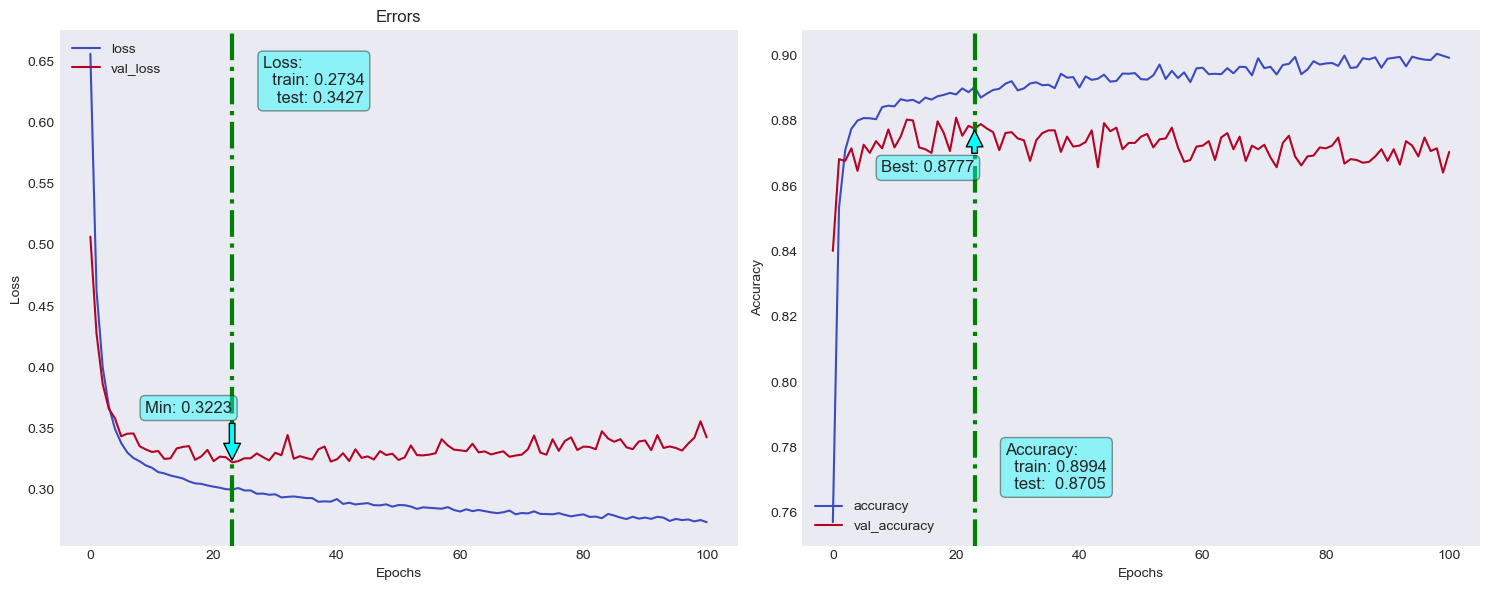

In [33]:
fn_plot_tf_hist(loss_df)